In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

sys.path.append('../')

from dataset import Pipeline, B, V
from dataset.models.tf import TFModel, RPN
from dataset.opensets import MNIST
from detection_mnist import DetectionMnist

In [2]:
IMAGE_SHAPE = (128, 128)
MNIST_PER_IMAGE = (5, 15)
RESIZE_TO = (14, 14)
ANCHORS_BATCH_SIZE = 16

BATCH_SIZE = 16

In [3]:
mnist = MNIST(batch_class=DetectionMnist)

ExtractingExtractingExtracting Extracting C:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz C:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gz 
C:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz
C:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gz



In [11]:
# feed_dict = {'images': B('images'),
#              'anchors': B('anchors'),
#              'anchors_cls': B('clsf'),
#              'anchors_reg': B('reg'),
#              'anchors_batch': B('anchor_batch'),
#              }    

feed_dict = {'images': B('images'),
             'labels': B('labels'),
             'bboxes': B('bboxes'),
             }    

feed_dict_rpn = {**feed_dict,
                'RPN/train_mode:0': True}

feed_dict_rcn = {**feed_dict,
                'RPN/train_mode:0': False}

In [12]:
placeholder_config = {'images': {'shape': IMAGE_SHAPE + (1,),
                                 'dtype': 'float32'}}

In [13]:
rpn_config = {'inputs': placeholder_config,
                'input_block/inputs': 'images',
                'batch_norm': {'momentum': 0.1},
                'map_shape': [],
                'loss': None,
                'optimizer': 'Adam'}

In [14]:
train_rpn = (mnist.train.p
            .init_variable('loss', init_on_each_run=list)
            .init_model('static', RPN, 'RPN', config=rpn_config)
            .generate_images(image_shape=IMAGE_SHAPE, 
                             n_digits=MNIST_PER_IMAGE, 
                             resize_to=RESIZE_TO)
            .train_model('RPN', 
                          feed_dict=feed_dict_rpn, 
                          fetches=['loss'], 
                          save_to=[V('loss')], mode='a'))

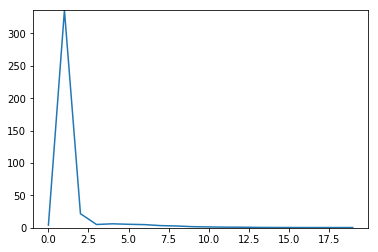

In [15]:
for i in range(20):
    train_rpn.next_batch(16)
    
    clear_output(True)
    current_max = np.max(train_rpn.get_variable('loss')[-20:])
    plt.plot(train_rpn.get_variable('loss'))
    plt.ylim([0,current_max])
    plt.show()

In [16]:
train_rcn = (mnist.train.p
            .init_variable('rpn_loss', init_on_each_run=list)
            .init_variable('rcn_loss', init_on_each_run=list)
            .import_model('RPN', train_rpn)
            .generate_images(image_shape=IMAGE_SHAPE, 
                             n_digits=MNIST_PER_IMAGE, 
                             resize_to=RESIZE_TO)
            .train_model('RPN', 
                          feed_dict=feed_dict_rpn, 
                          fetches=['loss'], 
                          save_to=[V('rpn_loss')], mode='a')
            .train_model('RPN', 
                          feed_dict=feed_dict_rcn, 
                          fetches=['loss'], 
                          save_to=[V('rcn_loss')], mode='a'))

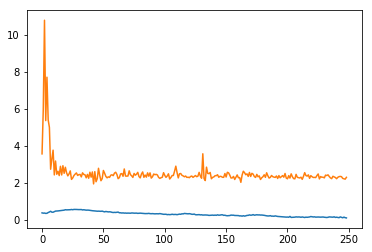

In [ ]:
for i in range(500):
    train_rcn.next_batch(16)
    clear_output(True)
    plt.plot(train_rcn.get_variable('rpn_loss'))
    plt.plot(train_rcn.get_variable('rcn_loss'))
    plt.show()